Add the DLH folder in the top-level of your Google Drive
Mount Colab to this location (only run once)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir("drive/My Drive/DLH_Project")

Mounted at /content/drive


Check that we are in the DLH_Project folder

In [ ]:
!ls

'Colab Notebooks'	    Proposal.gdoc
'Formatted Proposal.docx'  'PW Dataloading & Resnet.ipynb'
 images			   'PW Densenet.ipynb'
 Paper_33.pdf		    steves_sandbox.ipynb
'Project Draft.docx'	    steves_sandbox_multi.ipynb
 Project_Requirement.pdf    train.zip
 Project_Template.doc


Load the necessary modules and set file paths


In [ ]:
import pandas as pd
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io, transform
import torch.nn as nn
import random
import numpy as np

In [ ]:
IMG_PATH =  '/content/drive/MyDrive/DLH_Project/images/'
TRAIN_CSV = '/content/drive/My Drive/DLH_Project/images/PneumoniaTrain.csv'  #input your train.csv file here
VALID_CSV = '/content/drive/MyDrive/DLH_Project/images/PneumoniaTest.csv'   #input your valid.csv file here

Create custom dataset for loading images from the filepaths specified in the CSV

In [ ]:
from torch.utils.data import Dataset 
from PIL import Image
class PneumoniaDataset(Dataset): 
  def __init__(self, csv_file, root_dir, transform = None): 
    df = pd.read_csv(csv_file)
    df.fillna(0, inplace=True)
    self.data_file = df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return(len(self.data_file))

  def __getitem__(self, idx): 
    path = self.data_file
    img_path = os.path.join(self.root_dir, self.data_file.iloc[idx, 0])
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    y = self.data_file.iloc[idx, 12]
    return image, y

Build x-ray dataset
Look at the dataset

Note: We will want to truncate the CSV to only the images we have loaded

In [ ]:
dataset = PneumoniaDataset(TRAIN_CSV, IMG_PATH, transforms.ToTensor())
# using the ToTensor transform to grab image shape easily

print(type(dataset))
print(len(dataset))

for i in range(5):
  print(i, dataset[i])
  print(i, "image shape: ", dataset[i][0].size())

<class '__main__.PneumoniaDataset'>
1145
0 (tensor([[[0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0235, 0.0275],
         [0.0314, 0.0314, 0.0275,  ..., 0.0196, 0.0235, 0.0275],
         [0.0314, 0.0275, 0.0275,  ..., 0.0157, 0.0275, 0.0275],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.4235, 0.4196, 0.4510],
         [0.0314, 0.0314, 0.0314,  ..., 0.5647, 0.5686, 0.5529],
         [0.0314, 0.0314, 0.0314,  ..., 0.6902, 0.6549, 0.6627]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0235, 0.0275],
         [0.0314, 0.0314, 0.0275,  ..., 0.0196, 0.0235, 0.0275],
         [0.0314, 0.0275, 0.0275,  ..., 0.0157, 0.0275, 0.0275],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.4235, 0.4196, 0.4510],
         [0.0314, 0.0314, 0.0314,  ..., 0.5647, 0.5686, 0.5529],
         [0.0314, 0.0314, 0.0314,  ..., 0.6902, 0.6549, 0.6627]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0235, 0.0275],
         [0.0314, 0.0314, 0.0275,  ..., 0.0196, 0.0235, 0.0275],
         [0.03

Dataloader


In [ ]:
def load_data(train_csv_filepath, test_csv_filepath, root_dir):
  img_transform = transforms.Compose([
  transforms.CenterCrop(320),
  transforms.Resize(224),
  transforms.ToTensor()
  ])
  train_data = PneumoniaDataset(train_csv_filepath, root_dir, transform = img_transform)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 2) 
  val_data = PneumoniaDataset(test_csv_filepath, root_dir, transform = img_transform)
  val_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 2) 
  return train_loader, val_loader

In [ ]:
train_loader, val_loader = load_data(TRAIN_CSV, VALID_CSV, IMG_PATH)

Example images


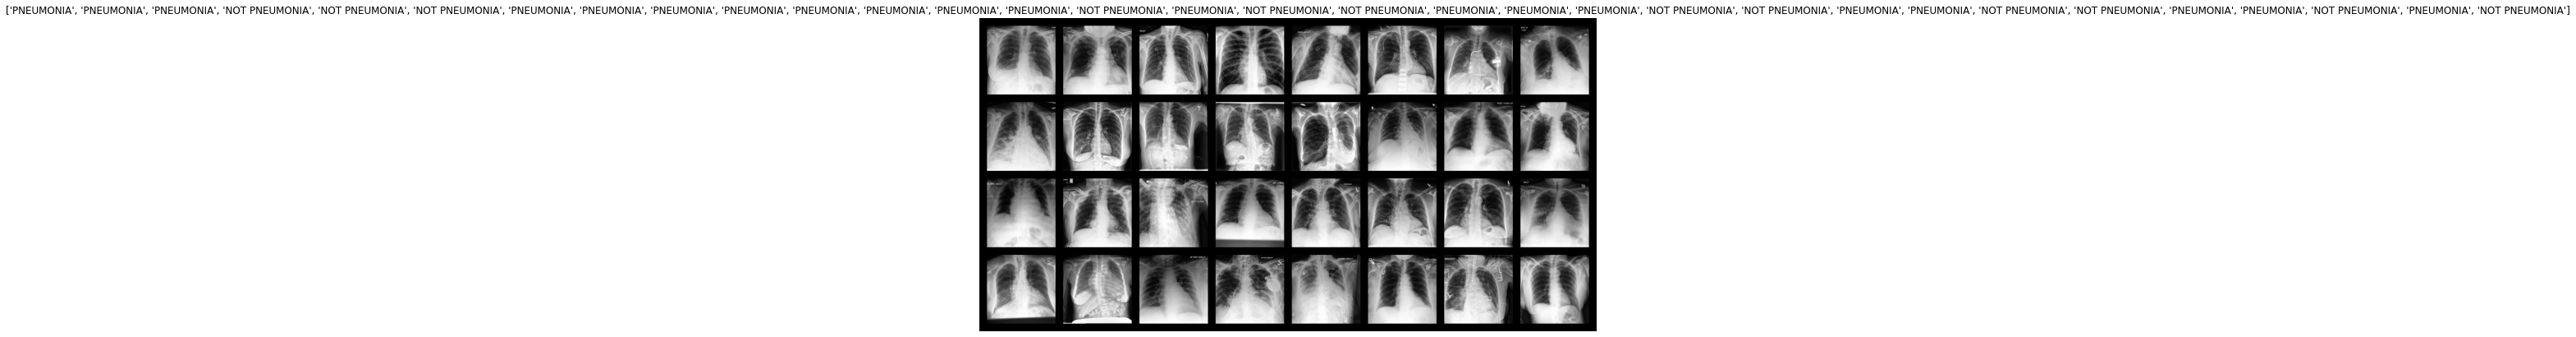

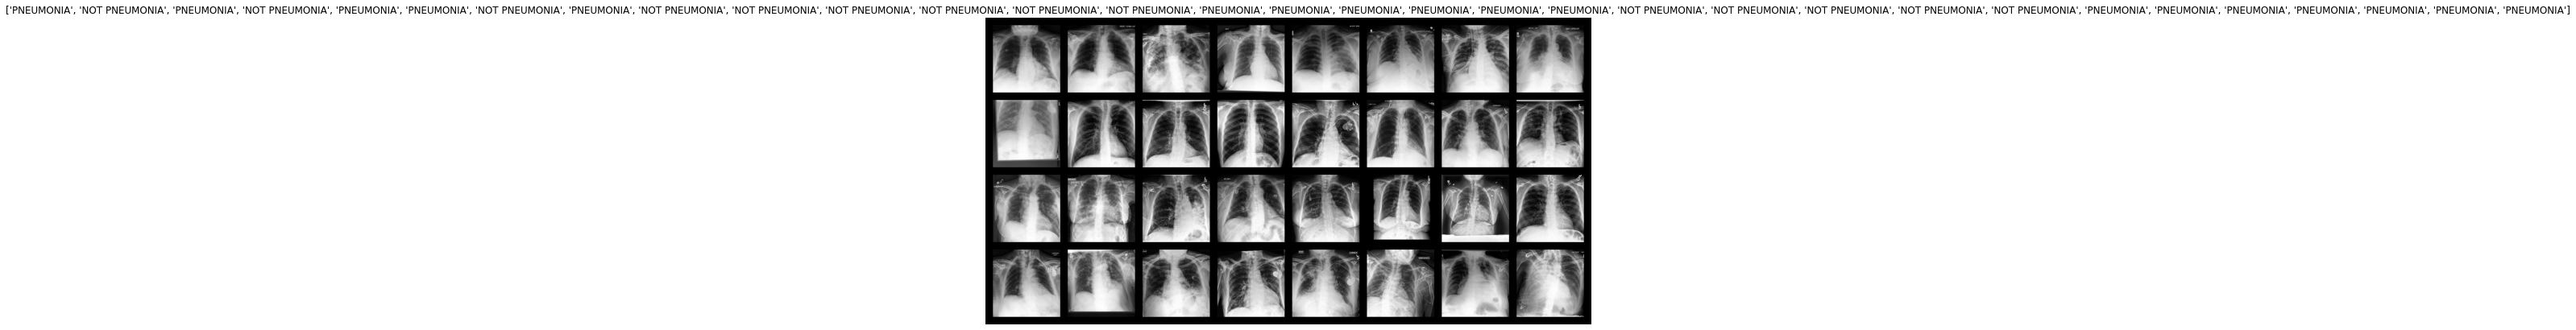

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["NOT PNEUMONIA" if x==0  else "PNEUMONIA" for x in labels])

for i in range(2):
    show_batch_images(train_loader)

Get the appropriate model, or build the model here

In [ ]:
def get_cnn_model():
    
    from torchvision import models
    
    num_classes = 2
    model = models.densenet121(num_classes = num_classes, memory_efficient = False)

    return model

In [ ]:
model = get_cnn_model()

Add critererion and optimizer for training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #changed to Adam from Resnet model

Train model

In [ ]:
n_epochs = 40

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    
    model.train() 
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model


In [ ]:
train_loader, val_loader = load_data(TRAIN_CSV, VALID_CSV, IMG_PATH)

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = train_model(model, train_loader)

Epoch 0: curr_epoch_loss=0.6231610774993896
Epoch 1: curr_epoch_loss=0.6077035665512085
Epoch 2: curr_epoch_loss=0.5681484341621399
Epoch 3: curr_epoch_loss=0.5837745070457458
Epoch 4: curr_epoch_loss=0.5703633427619934
Epoch 5: curr_epoch_loss=0.5474662184715271
Epoch 6: curr_epoch_loss=0.5427924990653992
Epoch 7: curr_epoch_loss=0.5581890940666199
Epoch 8: curr_epoch_loss=0.5290799736976624
Epoch 9: curr_epoch_loss=0.5235967636108398
Epoch 10: curr_epoch_loss=0.5286402702331543
Epoch 11: curr_epoch_loss=0.5298561453819275
Epoch 12: curr_epoch_loss=0.5192988514900208
Epoch 13: curr_epoch_loss=0.5014563202857971
Epoch 14: curr_epoch_loss=0.5135912895202637
Epoch 15: curr_epoch_loss=0.5185792446136475
Epoch 16: curr_epoch_loss=0.47086042165756226
Epoch 17: curr_epoch_loss=0.5093393921852112
Epoch 18: curr_epoch_loss=0.44504743814468384
Epoch 19: curr_epoch_loss=0.48867878317832947
Epoch 20: curr_epoch_loss=0.4460429549217224
Epoch 21: curr_epoch_loss=0.42134353518486023
Epoch 22: curr_e

Save model state for future use

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/DLH_Project/Colab Notebooks/PneumoniaDensenet40Epochs.pth')

Evaluate model using appropriate metrics

In [ ]:
def eval_model(model, dataloader):
    model.eval()
    Y_pred = []
    Y_test = []
    Y_prob = []
    for data, target in dataloader:
        output = model(data)
        Y_pred_prob_temp = torch.nn.functional.softmax(output, dim=1)[:,1]
        Y_prob.append(Y_pred_prob_temp.detach().numpy())
        Y_pred.append(torch.round(Y_pred_prob_temp).detach().numpy().astype('i'))
        Y_test.append(target)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    Y_prob = np.concatenate(Y_prob, axis = 0)

    return Y_pred, Y_test, Y_prob

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred, y_true, y_prob = eval_model(model, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))

Validation Accuracy: 0.7912663755458516


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print("F1: " + str(f1))

F1: 0.86831955922865


In [ ]:
roc_auc = roc_auc_score(y_true, y_prob)
print(roc_auc)

0.9545844547927258
